# Approximated Vornoi Diagrams
- The method performs a tournament between the Voronoi sites for regions of influence. The algorithm would inflate a ball around each point (site) with constant speed. A point x belongs to site p if p is the first ball to contain x. When two or more balls intersect, a point would be chosen as the representative of the balls in the tournament. The union of all balls should eventually cover the entire space R^d. 

- Below algorithm uses method proposed by Har-Peled (https://graphics.stanford.edu/courses/cs468-06-fall/Papers/07%20har-peled%20-%20focs%202001.pdf)

In [1]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import sys
sys.path.append(r'\Users\Mochi\AppData\Local\Programs\Python\Python310\Lib\site-packages')
import quads
import numpy as np
from sklearn.cluster import KMeans
import math
import matplotlib.patches as patches
import statistics as stat

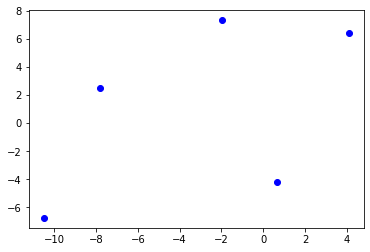

In [2]:
X, y = make_blobs(n_samples=5, centers=5, n_features=2,random_state=100)
plt.scatter(X[:,0], X[:,1], c='blue');
plt.show();

# Step 1: Heiarchical Clustering
## A. Compute lamda-approximated MST

In [3]:
labels = np.array([range(X.shape[0])])
size = X.shape[0]
dim = X.shape[1]
x = np.array([range(5)])
X_with_label = np.concatenate((X, x.T), axis=1)
lam = 2 # lam > 0
gamma = 0.4 # gamma < 1/2

In [4]:
def distance(p1, p2, X):
    """
    if p1 != p2, then compute min distance between a point in p1 and a point in p2
    
    otherwise, compute min distance between 2 points in X
    
    *assumed no duplicates
    """
    min_D = sys.maxsize
    if p1.all() == p2.all():
        for x in range(X.shape[0]):
            for y in range(X.shape[0]):
                if not x==y:
                    min_D = min(math.dist(X[x], X[y]), min_D)
    else:
        for x in p1:
            for y in p2:
                min_D = min(math.dist(X[x], X[y]), min_D)
    return min_D
def divide_P(X, pairs): 
    p1 = []
    p2 = []
    if not len(pairs) == 0:
        for (u,v) in pairs:
            if not u in p1:
                p1.append(u)
            if not v in p1:
                p1.append(v)
        for x in range(len(X)):
            if not x in p1:
                p2.append(x)
    return np.array(p1), np.array(p2)
def compute_min_span_tree(X, lam):
    size = X.shape[0]
    mst = []
    edge = []
    while not len(mst)==size-1:
     #length should be n-1 pairs
        for u in range(size):
            if len(mst)==size-1:
                break
            for v in range(size):
                if not u==v and not (u,v) in mst and not (v,u) in mst:
                    len_e = math.dist(X[u], X[v])
                    p1, p2 = divide_P(X, mst)
                    if len(p1)==0:
                        dist = distance(X,X,X)
                    else:
                        dist = distance(p1, p2, X)
                    if len_e <= dist and dist <= lam*len_e:
                        mst.append((u,v))
                        edge.append(math.dist(X[u], X[v]))
                        break
    mst = np.array(mst)
    edge = np.array([edge])
    mst_with_edge = np.concatenate((mst, edge.T), axis=1)
    return mst, edge, mst_with_edge

In [5]:
mst, edge, mst_with_edge = compute_min_span_tree(X, lam)

In [6]:
mst_with_edge

array([[ 1.        ,  4.        ,  6.12457347],
       [ 0.        ,  1.        ,  7.55076122],
       [ 2.        ,  0.        ,  9.66582598],
       [ 3.        ,  0.        , 10.80980414]])

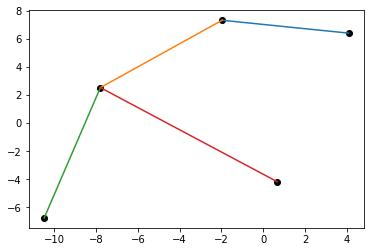

In [7]:
###plot MST
for (u,v) in mst:
    x_val = np.array([X[u][0], X[v][0]])
    y_val = np.array([X[u][1], X[v][1]])
    plt.plot(x_val, y_val)
plt.scatter(X[:,0], X[:,1], c='black');
plt.show()

## B. Compute Directed Tree
- this also computes r-loss values

In [8]:
class DirectedTree:
    def __init__(self, node_id, point):
        self.node_id = node_id
        self.point = point
        self.parent = None
        self.children = []
    def __repr__(self):
        return 'Tree {}: Point: {}, Children: {}'.format(str(self.node_id), str(self.point), str(self.children))
    def add_child(self, child):
        self.children.append(child)
    def merge_tree(self, t2, mst):
        if len(self.children) == 0 and len(t2.children) == 0:
            self_count = np.count_nonzero(mst == self.node_id)
            t2_count = np.count_nonzero(mst == t2.node_id)
            if self_count >= t2_count:
                self.add_child(t2)
                t2.parent = self
                return self, self.node_id, t2.node_id
            else:
                t2.add_child(self)
                self.parent = t2
                return t2, t2.node_id, self.node_id
        elif len(self.children) > len(t2.children):
            self.add_child(t2)
            t2.parent = self
            return self, self.node_id, t2.node_id
        else:
            t2.add_child(self)
            self.parent = t2
            return t2, t2.node_id, self.node_id
def get_tree(forest, idx, merge):
    for tree in forest:
        if tree.node_id == idx:
            return tree
    for (new, remove) in merge:
        if remove == idx:
            for tree in forest:
                if tree.node_id == new:
                    for c in tree.children:
                        if c.node_id == remove:
                            return c
def compute_directed_tree(X, mst_with_edge):
    forest = []
    for t in range(len(X)):
        forest.append(DirectedTree(t, X[t]))
    temp_mst = mst_with_edge
    temp_forest = forest
    merge_history = []
    r_loss = []
    while not len(temp_mst) == 0:
        u = temp_mst[0][0]
        v = temp_mst[0][1]
        u = get_tree(temp_forest, u, merge_history)
        v = get_tree(temp_forest, v, merge_history)
        new_tree, new_id, removed_id = DirectedTree.merge_tree(u, v, mst)
        r_loss.append([new_id, removed_id, temp_mst[0][2]/2])
        temp_mst = np.delete(temp_mst, 0, 0)
        temp_forest.remove(get_tree(temp_forest, removed_id, merge_history))
        merge_history.append((new_id, removed_id))
    return temp_forest, r_loss
def reorder_rloss(r_loss, X): ##id -> r_loss
    r_loss = np.array(r_loss)
    new_r = np.zeros((X.shape[0], 1))
    for r in range(r_loss.shape[0]):
        new_r[int(r_loss[r][1])] = r_loss[r][2]
    return new_r
def compute_rdeath(r_loss, lam, gamma):
    return 6 * lam * r_loss * math.log(X.shape[0],2) * X.shape[0] / gamma
def compute_rmedian(X_rloss):
    return stat.median(X_rloss)
def compute_rtop(r_median, X, P, lam, gamma): #P entire point-set, X is subset of P
    return((36*lam*X.shape[0]*math.log(P.shape[0],2))/gamma)*r_median

In [9]:
forest, r_loss = compute_directed_tree(X, mst_with_edge)
forest

[Tree 1: Point: [-1.96767517  7.33068613], Children: [Tree 4: Point: [4.0877025  6.41264396], Children: [], Tree 0: Point: [-7.79714858  2.53159927], Children: [Tree 2: Point: [-10.48921793  -6.75177051], Children: [], Tree 3: Point: [ 0.678603   -4.17761085], Children: []]]]

In [10]:
r_loss = reorder_rloss(r_loss, X)
r_loss

array([[3.77538061],
       [0.        ],
       [4.83291299],
       [5.40490207],
       [3.06228673]])

In [13]:
r_death = compute_rdeath(r_loss, lam, gamma)
r_death

array([[1314.92434568],
       [   0.        ],
       [1683.25146832],
       [1882.46909476],
       [1066.56144044]])

In [14]:
r_median = compute_rmedian(r_loss)
r_median[0]

3.775380608842835

In [15]:
r_top = compute_rtop(r_median, X, X, lam, gamma)
r_top

array([7889.54607411])

# Step 2: Build NN Search Tree

In [17]:
class NNSearchNode:
    def __init__(self):
        # self.r_negative = None
        # self.r_positive = None
        # self.P = None
        self.outer = None
        self.inner = []
        self.IPLEB = None
    def __repr__(self):
        return 'Node -- Outer: {}, Inner: {}'.format(str(self.outer), str(self.inner))
    def add_outer(self, outer):
        self.outer = outer
    def add_inner(self, inner):
        self.inner.append(inner)
class NNSearchTree:
    def __init__(self):
        self.root = None
    def __repr__(self):
        return 'Root: {}'.format(str(self.root))
    def add_root(self, root):
        self.root = root
    def query(self, q):
        """
        compute min distance between a point in self.P and q
        """
        print('looking for {}...'.format(str(q)))
        v = self.root
        print('current points in tree: {}'.format(v.P))
        min_D = sys.maxsize
        for p in range(len(v.IPLEB.P)):
            if min_D > math.dist(v.IPLEB.P[p],q):
                u = v.IPLEB.P[p]
                min_D = math.dist(v.IPLEB.P[p],q)
        if min_D > v.r_positive:
            print("min_D >= v+")
            return query(v.outer, q)
        if v.r_negative <= min_D and min_D <= v.r_positive:
            print("v- <= min_D <= v+")
            for p in range(len(v.IPLEB.P)):
                if (1+v.IPLEB.e)*min_D >= math.dist(self.P[p],q):
                    u = self.P[p]
                    print(u)
                    return u
        print("min_D <= v-")
        for cc in v.cc:
            print(X[cc])
            if len(cc) == 1 :##and v.M[cc]==u:
                print(X[cc])
                return X[cc]
class IPLEB:
    def __init__(self,P,a,b,e):
        self.P = P
        self.a = a
        self.b = b
        self.e = e
class Ball:
    def __init__(self, point, rad, site):
        self.point = point
        self.rad = rad
        self.site = site
    def __repr__(self):
        return 'Ball: Point: {}, Radius: {}, Site no.{}'.format(str(self.point), str(self.rad), str(self.site))

In [18]:
def connected_component(X, r):
    cc = []
    for x in range(X.shape[0]):
        temp = []
        temp.append(x)
        for y in range(x+1,X.shape[0]):
            if math.dist(X[x],X[y])<=2*r:
                temp.append(y) 
        cc.append(temp)
    have_duplicate = True
    while have_duplicate:
        have_duplicate = False
        for i in range(len(cc)): 
            for j in range(i+1, len(cc)):
                if len(set(cc[i]).intersection(cc[j]))>0:
                    cc[i] = list(set(cc[i]).union(cc[j]))
                    cc.pop(j)
                    have_duplicate = True
                    break
            break
    return cc

In [22]:
def buildNNTree(M, M_rloss, M_rdeath, lam, gamma, r_min, r_max, P, M_with_label):
    tree = NNSearchTree()
    v = NNSearchNode()
    v.r_max = r_max
    r_median = compute_rmedian(M_rloss)[0]
    v.r_negative = max(r_median, r_min)
    v.r_positive = min(compute_rtop(r_median, M, P, lam, gamma), r_max)
    v.P = M_with_label
    # print('received r_min: {}, r_max: {}, r_median: {}, r_top: {}, all points: {}'.format(str(r_min), str(r_max), str(r_median), str(compute_rtop(r_median, M, P, lam, gamma)), str(M)))
    # print('r-: {}, r+: {}'.format(str(v.r_negative), str(v.r_positive)))
    if v.r_negative >= v.r_positive: 
        tree.add_root(v)
        return tree
    #compute inner pleb
    v.IPLEB = IPLEB(M, v.r_negative, v.r_positive, gamma/3)
    #compute M+
    # print("compute M+")
    m_plus = []
    for r in range(len(M_rdeath)):
        if M_rdeath[r] > v.r_positive:
            m_plus.append(r)
    m_plus = np.array(m_plus)
    # print(m_plus)
    M_positive = M[m_plus]
    new_rloss = M_rloss[m_plus]
    new_rdeath = M_rdeath[m_plus]
    if not len(M_positive) == 0:
        # print("build outer tree")
        T = buildNNTree(M_positive, new_rloss, new_rdeath, lam, gamma, v.r_positive, r_max, P, M_with_label[m_plus])
        v.add_outer(T)
    cc = connected_component(M,v.r_negative)
    v.cc = cc
    # print("cc")
    # print(cc)
    for x in cc:
        if len(x) > 1:
            # print("compute inner")
            v.add_inner(buildNNTree(np.array(M[x]),np.array(M_rloss[x]), np.array(M_rdeath[x]), lam, gamma, r_min, v.r_negative, P, np.array(M_with_label[x])))
    # print(v)
    tree.add_root(v)
    return tree

In [23]:
max_r = max(mst_with_edge[:,-1])/2
min_r = min(mst_with_edge[:,-1])/2
max_r, min_r

(5.404902069403021, 3.062286734295503)

In [24]:
b = buildNNTree(X, r_loss, r_death, lam, gamma, min_r, max_r, X, X_with_label)

In [25]:
def totuple(a):
    try:
        return tuple(totuple(i) for i in a)
    except TypeError:
        return a
def get_all_balls(tree):
    node = tree.root
    return get_balls(node)
def get_balls(node):
    balls = []
    for p in node.P:
        site = p[-1]
        #balls.append(Ball(p[:-1], node.r_max, int(site)))
        balls.append((totuple(p[:-1]), node.r_max, int(site)))
        if not node.IPLEB == None:
            #balls.append(Ball(p[:-1], node.IPLEB.a, int(site)))
            balls.append((totuple(p[:-1]), node.IPLEB.a, int(site)))
            if not node.IPLEB.b == node.r_max:
                #balls.append(Ball(p[:-1], node.IPLEB.b, int(site)))
                balls.append((totuple(p[:-1]), node.IPLEB.b, int(site)))
    if not node.outer == None:
        balls.append(get_all_balls(node.outer))
    if not len(node.inner) == 0:
        for i in node.inner:
            balls.append(get_all_balls(i))
    return balls
## referenced at https://stackoverflow.com/questions/12472338/flattening-a-list-recursively
def flatten(S):
    if S == []:
        return S
    if isinstance(S[0], list):
        return flatten(S[0]) + flatten(S[1:])
    return S[:1] + flatten(S[1:])

# Step 3: Identify all 'critical' balls for the tournament

In [26]:
balls = set(flatten(get_all_balls(b)))
balls

{((-10.489217926503212, -6.7517705126519365), 3.775380608842835, 2),
 ((-10.489217926503212, -6.7517705126519365), 5.404902069403021, 2),
 ((-7.7971485831528495, 2.5315992736783453), 3.062286734295503, 0),
 ((-7.7971485831528495, 2.5315992736783453), 3.775380608842835, 0),
 ((-7.7971485831528495, 2.5315992736783453), 5.404902069403021, 0),
 ((-1.9676751705199629, 7.330686134520967), 3.062286734295503, 1),
 ((-1.9676751705199629, 7.330686134520967), 3.775380608842835, 1),
 ((-1.9676751705199629, 7.330686134520967), 5.404902069403021, 1),
 ((0.6786030049961334, -4.1776108538506955), 3.775380608842835, 3),
 ((0.6786030049961334, -4.1776108538506955), 5.404902069403021, 3),
 ((4.087702500245234, 6.412643958710326), 3.062286734295503, 4),
 ((4.087702500245234, 6.412643958710326), 3.775380608842835, 4),
 ((4.087702500245234, 6.412643958710326), 5.404902069403021, 4)}

In [27]:
len(balls)

13

# Step 4: Convert balls found in Step 3 into cubes
## A. Compute bounding box that covers all points in X

In [28]:
bounding_box_length = math.ceil(max(max(np.absolute(X[:,0])),max(np.absolute(X[:,1]))))*2
bounding_box_length
box_point = np.array([-bounding_box_length/2,bounding_box_length/2])#upper left of box

In [29]:
box_point

array([-11.,  11.])

## B. Find all cubes that intersects with balls found in Step 3

In [30]:
class Cube:
    def __init__(self, point, side, site):
        self.point = point
        self.side = side
        self.site = site
    def __repr__(self):
        return 'Cube: Point: {}, Side length: {}, Site no.{}'.format(str(self.point), str(self.side), str(self.site))

In [36]:
##https://www.geeksforgeeks.org/check-if-any-point-overlaps-the-given-circle-and-rectangle/
def checkOverlap(R, Xc, Yc, X1, Y1, X2, Y2):
 
    # Find the nearest point on the
    # rectangle to the center of
    # the circle
    Xn = max(X1, min(Xc, X2))
    Yn = max(Y1, min(Yc, Y2))
     
    # Find the distance between the
    # nearest point and the center
    # of the circle
    # Distance between 2 points,
    # (x1, y1) & (x2, y2) in
    # 2D Euclidean space is
    # ((x1-x2)**2 + (y1-y2)**2)**0.5
    Dx = Xn - Xc
    Dy = Yn - Yc
    return (Dx**2 + Dy**2) <= R**2
def ball_to_cube(X, epsilon, balls, box_point, bounding_box_length):
    """
    Parameter
    ---------
    epsilon : float
    approximate factor, should be >0
    
    
    """
    cubes = []
    border = []
    d = X.shape[1]
    side = sys.maxsize
    for ball in balls:
        u = (ball[-2] * epsilon)/(3*d)
        side = min(side, math.pow(2, math.floor(math.log(u, 2))))

    count = math.ceil(bounding_box_length/side)
    check_border = np.full((count+1, count+1), False)
    cubes_label = np.full((count+1, count+1), size)
    prev = size
    for i in range(count+1): #row
        for j in range(count+1): #col
            add = False
            for ball in balls:
                if checkOverlap(ball[-2], ball[0][0], ball[0][1], box_point[0]+j*side, box_point[1]-i*side, box_point[0]+(j+1)*side, box_point[1]-(i+1)*side):
                    if not prev == ball[-1]:
                        check_border[i][j] = True
                        border.append(np.array([box_point[0]+j*side, box_point[1]-i*side, box_point[0]+j*side, box_point[1]-(i+1)*side])) 
                    cubes.append(Cube(np.array([box_point[0]+j*side, box_point[1]-(i+1)*side]), side, ball[-1]))
                    add = True
                    prev = ball[-1]
                    break
            if not add:
                if not prev == size:
                        border.append(np.array([box_point[0]+j*side, box_point[1]-i*side, box_point[0]+j*side, box_point[1]-(i+1)*side])) 
                # cubes_array.append(np.array([box_point[0]+j*side, box_point[1]-(i+1)*side, side, size]))
                prev = size
    
    return cubes, border            

In [37]:
epsilon = 1
cubes, border = ball_to_cube(X, epsilon, balls, box_point, bounding_box_length)

In [38]:
len(cubes)

1418

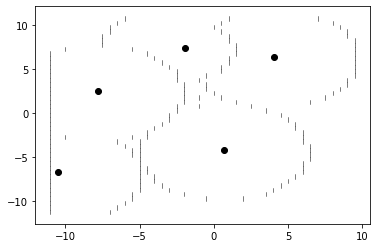

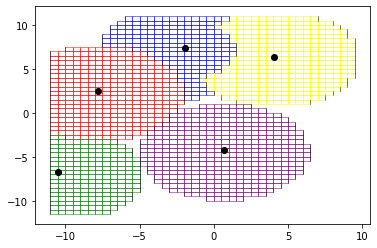

In [39]:
fig, ax1 = plt.subplots(1, 1)
colors = ['red', 'blue', 'green', 'purple', 'yellow', 'black']
# for c in cubes:
#     rect = patches.Rectangle((c.point[0], c.point[1]), c.side, c.side, linewidth=0.5, edgecolor=colors[c.site], facecolor='none')
#     ax1.add_patch(rect)
for b in border:
    x = np.array([b[0], b[2]])
    y = np.array([b[1], b[3]])
    plt.plot(x,y,linewidth=0.5, color='black')
plt.scatter(X[:,0], X[:,1], c='black');
plt.show();

fig, ax1 = plt.subplots(1, 1)
colors = ['red', 'blue', 'green', 'purple', 'yellow', 'black']
for c in cubes:
    rect = patches.Rectangle((c.point[0], c.point[1]), c.side, c.side, linewidth=0.5, edgecolor=colors[c.site], facecolor='none')
    ax1.add_patch(rect)
for b in border:
    x = np.array([b[0], b[2]])
    y = np.array([b[1], b[3]])
    plt.plot(x,y,linewidth=0.5, color='black')
plt.scatter(X[:,0], X[:,1], c='black');
plt.show();

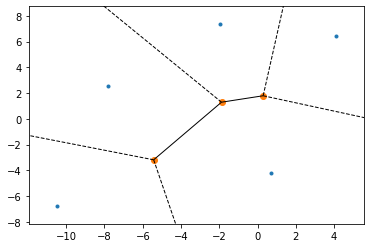

In [40]:
from scipy.spatial import Voronoi, voronoi_plot_2d
vor = Voronoi(X)
fig = voronoi_plot_2d(vor)
plt.show()